In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import nltk

from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud, ImageColorGenerator

from textblob import TextBlob

from utils import stop_words, make_corpus_df, get_data_between_dates, get_data_by_year, get_data_by_channel, make_list_of_processed_snippets

In [98]:
def polarity_classification(sentiment_score):
    if sentiment_score > 0.25:
        return 'positive'
    elif -0.25 <= sentiment_score <= 0.25:
        return 'neutral'
    else:
        return 'negative'

def subjectivity_classificiation(subjectivity_score):
    if subjectivity_score >= 0.5:
        return 'subjective'
    else:
        return 'objective'

def create_document(list_of_processed_snippets):
    return ' '.join(list_of_processed_snippets)

In [84]:
PARENT = 'TelevisionNewsV2'

In [85]:
corpus_df = make_corpus_df(PARENT)

In [86]:
corpus_df = corpus_df[['DateTime', 'Station', 'Show', 'IAShowID', 'Snippet']]
corpus_df['Snippet'] = make_list_of_processed_snippets(corpus_df, stop_words)

In [87]:
corpus_df['polarity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).polarity, axis=1)
corpus_df['subjectivity'] = corpus_df.apply(lambda row: TextBlob(row['Snippet']).subjectivity, axis=1)
corpus_df['sentiment_class'] = corpus_df.apply(lambda row: polarity_classification(row['polarity']), axis=1)
corpus_df['subjectivity_class'] = corpus_df.apply(lambda row: subjectivity_classificiation(row['subjectivity']), axis=1)

In [90]:
# cnn['sentiment_class'].value_counts()
# msnbc['sentiment_class'].value_counts()
# foxnews['sentiment_class'].value_counts()

neutral     19472
positive     4574
negative     1819
Name: sentiment_class, dtype: int64

In [30]:
# cnn['subjectivity_class'].value_counts()
# msnbc['subjectivity_class'].value_counts()
# foxnews['subjectivity_class'].value_counts()

objective     15861
subjective    10004
Name: subjectivity_class, dtype: int64

In [27]:
cnn = corpus_df[corpus_df['Station'] == 'CNN']
msnbc = corpus_df[corpus_df['Station'] == 'MSNBC']
foxnews = corpus_df[corpus_df['Station'] == 'FOXNEWS']

In [91]:
stations = ['CNN', 'Fox News', 'MSNBC']

positive_counts = [3623, 4574, 4834]
neutral_counts = [14727, 19472, 20202]
negative_counts = [954, 1819, 1393]

subjective_counts = [7698, 10004, 10007]
objective_counts = [11606, 15861, 16422]

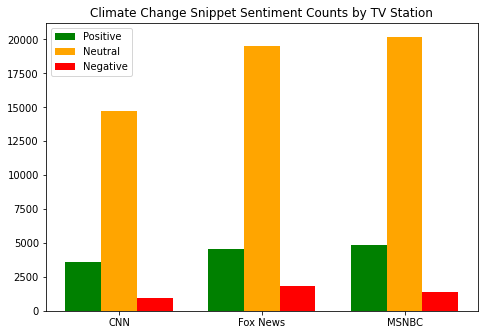

In [92]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, positive_counts, color='g', width=width, label="Positive")
ax.bar(X + 1*width, neutral_counts, color='orange', width=width, label="Neutral")
ax.bar(X+ 2*width, negative_counts, color='r', width=width, label="Negative")
ax.set_title("Climate Change Snippet Sentiment Counts by TV Station")
ax.set_xticks(X + width)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

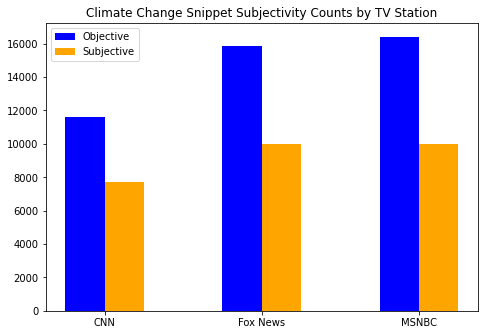

In [81]:
X = np.arange(3)

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
width = 0.25

ax.bar(X + 0*width, objective_counts, color='blue', width=width, label="Objective")
ax.bar(X + 1*width, subjective_counts, color='orange', width=width, label="Subjective")
ax.set_title("Climate Change Snippet Subjectivity Counts by TV Station")
ax.set_xticks(X + width/2)
ax.set_xticklabels(('CNN', 'Fox News', 'MSNBC'))
ax.legend()
plt.show()

In [138]:
cnn_document = create_document(cnn['Snippet'].to_list())
fox_document = create_document(foxnews['Snippet'].to_list())
msnbc_document = create_document(msnbc['Snippet'].to_list())

In [139]:
corpus_by_station = [cnn_document, fox_document, msnbc_document]
whole_corpus_vectorizer = TfidfVectorizer()
X_whole_corpus = whole_corpus_vectorizer.fit_transform(corpus_by_station)

In [140]:
X_whole_corpus = X_whole_corpus.toarray()
whole_corpus_feature_array = np.array(whole_corpus_vectorizer.get_feature_names())

In [142]:
cnn_tfidf_vector = X_whole_corpus[0, :]
top_cnn_indices = cnn_tfidf_vector.argsort()[::-1]
fox_tfidf_vector = X_whole_corpus[1, :]
top_fox_indices = fox_tfidf_vector.argsort()[::-1]
msnbc_tfidf_vector = X_whole_corpus[2, :]
top_msnbc_indices = msnbc_tfidf_vector.argsort()[::-1]

In [156]:
n = 30

In [157]:
top_n_cnn_important_words = whole_corpus_feature_array[top_cnn_indices][:n]
top_n_cnn_important_words

array(['president', 'issue', 'think', 'talk', 'people', 'trump', 'world',
       'know', 'right', 'want', 'year', 'new', 'well', 'state', 'would',
       'said', 'country', 'time', 'he', 'gas', 'lot', 'also', 'believe',
       'scientist', 'greenhouse', 'could', 'back', 'thing', 'see',
       'reporter'], dtype='<U30')

In [158]:
top_n_fox_important_words = whole_corpus_feature_array[top_fox_indices][:n]
top_n_fox_important_words

array(['president', 'people', 'think', 'know', 'want', 'issue', 'would',
       'new', 'right', 'year', 'said', 'world', 'gas', 'time', 'go',
       'well', 'obama', 'bill', 'believe', 'state', 'country',
       'greenhouse', 'way', 'look', 'talk', 'lot', 'saying', 'come',
       'say', 'trump'], dtype='<U30')

In [159]:
top_n_msnbc_important_words = whole_corpus_feature_array[top_msnbc_indices][:n]
top_n_msnbc_important_words

array(['president', 'think', 'people', 'issue', 'know', 'right',
       'republican', 'new', 'year', 'want', 'well', 'country', 'state',
       'trump', 'would', 'time', 'said', 'believe', 'world', 'he', 'way',
       'gas', 'talk', 'back', 'lot', 'thing', 'look', 'really', 'see',
       'need'], dtype='<U30')